# Quick start - пишем очень простое решение

In [83]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from tqdm.notebook import tqdm

In [25]:
!ls ../data/

car_info.csv	      fix_info.csv    test_data.csv	   tmp_rides_info.csv
datafeeling_test.csv  rider_info.csv  tmp_car_info.csv	   train_data.csv
driver_info.csv       rides_info.csv  tmp_driver_info.csv


# Анализируем данные о машинах car_info

(2337, 9)


,car_type,fuel_type,car_rating,year_to_start,riders,car_id,model,target_2,year_to_work
2192,economy,petrol,22.3,2015,17748,p14898028j,Smart ForTwo,engine_overheat,2018
1683,economy,petrol,15.9,2015,18010,z57656268e,Hyundai Solaris,engine_ignition,2015
1072,economy,petrol,21.9,2013,14182,f26286492n,Skoda Rapid,another_bug,2021
1323,business,petrol,22.7,2015,22780,L15915754W,Fiat 500,engine_overheat,2015
196,economy,petrol,26.2,2015,18137,d18230401U,Smart ForFour,another_bug,2017


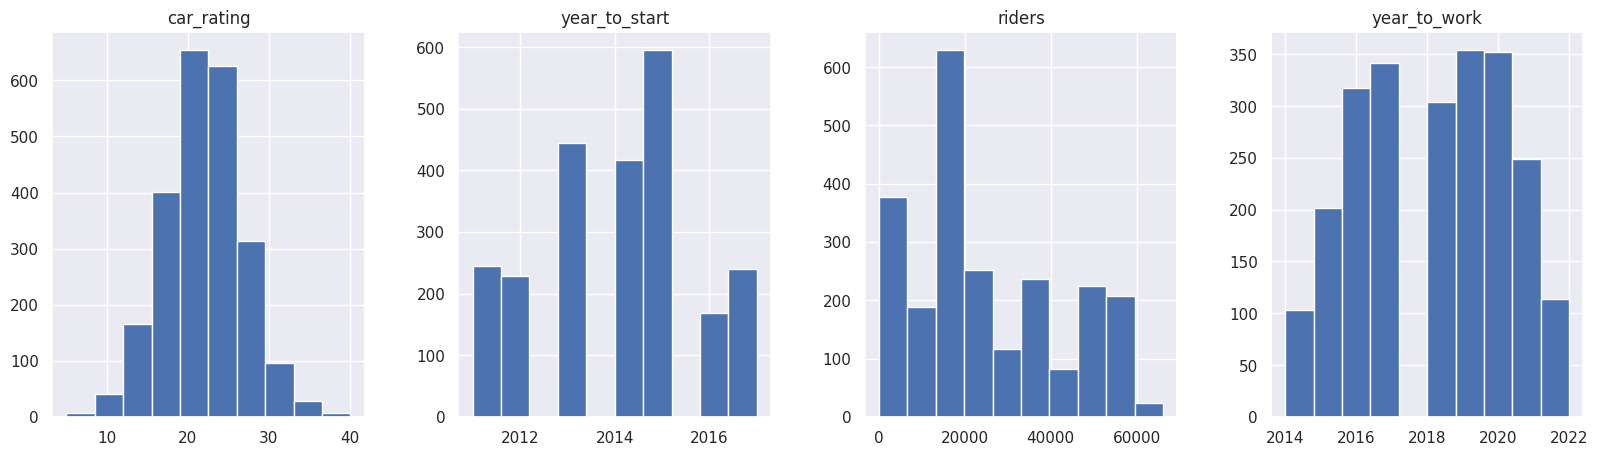

In [30]:
car_train = pd.read_csv('../data/car_train.csv').drop('target_1', axis=1)
print(car_train.shape)
car_train.hist(figsize=(25, 5), layout = (-1, 5))
car_train.sample(5)

In [48]:
car_test = pd.read_csv('../data/car_test.csv').drop('target_1', axis=1)
print(car_test.shape)
car_test[['car_id', 'target_2']].to_csv('../data/solution.csv', index=False)
car_test.sample(5)

(1913, 9)


,car_type,fuel_type,car_rating,year_to_start,riders,car_id,model,target_2,year_to_work
802,standart,petrol,14.9,2015,15381,Y82809565p,Nissan Qashqai,another_bug,2014
829,standart,petrol,22.6,2011,55146,s-2199790Y,Kia Sportage,engine_fuel,2018
1886,economy,petrol,24.1,2017,48213,I-4266636F,VW Tiguan,another_bug,2020
1416,economy,petrol,21.6,2013,18622,T-3892356u,Kia Rio X-line,gear_stick,2016
588,business,petrol,20.0,2011,56758,O-3808140b,Mercedes-Benz GLC,engine_check,2020


In [101]:
features2drop = ['car_id'] 
targets = ['target_2']  #
cat_features = ['car_type', 'fuel_type', 'model'] 

filtered_features = [i for i in car_train.columns if (i not in targets and i not in features2drop)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features', cat_features)
print('num_features', len(num_features))
print('targets', targets)

for c in cat_features:
    df[c] = df[c].astype(str)

cat_features ['car_type', 'fuel_type', 'model']
num_features 11
targets ['target_2']


# Catboost model

In [100]:
from sklearn.model_selection import KFold # k-фолдная валидация
from catboost import Pool, CatBoostClassifier#, CatBoostRegressor 

In [98]:

targets = ['target_2']

X = car_train[filtered_features].drop(targets, axis=1, errors='ignore')
y = car_train[targets]

clf = CatBoostClassifier(iterations = 700,
                      loss_function='MultiClass', 
                      random_seed=42,                          
                      colsample_bylevel =  0.098,
                      subsample = 0.95,
                      min_data_in_leaf = 243,
                      bootstrap_type='Bernoulli')


clf.fit(train_dataset, verbose = 250, plot = False)

# инференс модели
y_pred = np.zeros((car_test.shape[0], 9)) # массив для записи финального результата
y_pred += clf.predict_proba(car_test[filtered_features])#[:,1]

Learning rate set to 0.109405
0:	learn: 2.1956616	total: 527us	remaining: 369ms
250:	learn: 0.7056048	total: 322ms	remaining: 576ms
500:	learn: 0.5339144	total: 632ms	remaining: 251ms
699:	learn: 0.4549638	total: 884ms	remaining: 0us


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


# Делаем прогноз на тест

In [99]:
car_test['target_2'] = clf.predict(car_test[filtered_features])
car_test[['car_id', 'target_2']].to_csv('../subs/simple_baseline.csv', index=False)

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


# Добавим информацию про поездки из rides

In [102]:
rides_df = pd.read_csv('../data/rides_info.csv')
rides_df.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
76791,V78702054K,F-8043423F,J1C,2020-01-31,5.08,39,306,62,100.732956,0,2523.697089,0,-11.398277,3.847
658073,j78047082e,u-1845226l,y1e,2020-01-04,4.94,30,353,37,69.000000,2,481.676716,0,-9.863802,15.092
386451,S42049124Z,b-2339374A,c1c,2020-03-31,2.45,83,1653,41,65.000000,0,2479.383266,0,-16.233557,0.583
220384,j20737247V,P39859325s,V1G,2020-02-22,3.73,33,423,44,73.000000,1,821.094846,0,4.507401,0.268
212210,q19362109c,P-5087291N,C1o,2020-02-25,0.58,36,462,42,123.000000,2,1377.629655,0,-14.462702,17.619


In [107]:

f = lambda x: x.nunique()
rides_df_gr = rides_info.groupby('car_id', as_index=False).agg(mean_rating = ('speed_avg', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1005804b,43.844828,7.299226e+07,0.1,133.982523,-1.560278,174,172
1,A-1008700v,51.229885,6.417507e+07,0.0,170.440726,-3.493546,174,173


In [78]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    return df
    
    
car_train = add_featues(car_train)
car_test = add_featues(car_test)

In [106]:
car_train.sample(2)

,car_type,fuel_type,car_rating,year_to_start,riders,car_id,model,target_2,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
1914,standart,petrol,22.9,2015,13486,q68563068A,Renault Kaptur,break_bug,2018,44.844828,5.064248e+07,1.15,114.212362,-3.102379,174,172
1292,standart,petrol,9.9,2012,32316,I70425477V,Kia Sportage,another_bug,2018,44.919540,7.555300e+07,0.10,172.079874,1.163708,174,172


In [80]:
df = car_train

features2drop = ['car_id'] 
targets = ['target_2']  #
cat_features = ['car_type', 'fuel_type', 'model'] 

filtered_features = [i for i in df.columns if (i not in targets and i not in features2drop)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features', cat_features)
print('num_features', len(num_features))
print('targets', targets)

for c in cat_features:
    df[c] = df[c].astype(str)

cat_features ['car_type', 'fuel_type', 'model']
num_features 11
targets ['target_2']


In [104]:
targets = ['target_2']

X = car_train[filtered_features].drop(targets, axis=1, errors='ignore')
y = car_train[targets]

clf = CatBoostClassifier(iterations = 700,
                      loss_function='MultiClass', 
                      random_seed=42,                          
                      colsample_bylevel =  0.098,
                      subsample = 0.95,
                      min_data_in_leaf = 243,
                      bootstrap_type='Bernoulli')


clf.fit(train_dataset, verbose = 250, plot = False)

# инференс модели
y_pred = np.zeros((car_test.shape[0], 9)) # массив для записи финального результата
y_pred += clf.predict_proba(car_test[filtered_features])#[:,1]

Learning rate set to 0.109405
0:	learn: 2.1956616	total: 551us	remaining: 385ms
250:	learn: 0.7056048	total: 312ms	remaining: 559ms
500:	learn: 0.5339144	total: 616ms	remaining: 245ms
699:	learn: 0.4549638	total: 873ms	remaining: 0us


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [103]:
car_test['target_2'] = clf.predict(car_test[filtered_features])
car_test[['car_id', 'target_2']].to_csv('../subs/simple_baseline_v2.csv', index=False)

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
